In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#!pip install --ignore-installed box2d-py
#!pip install gym[Box_2D]
import pickle
import gym
import copy
import math
import os
from collections import namedtuple
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import tqdm

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#base_path = '/content/gdrive/My Drive/rl/'
base_path = 'sac-results/'

#gym.make("BipedalWalker-v2")
envs = {
    'cartpole': gym.make('CartPole-v1'),
#    'mountaincar': gym.make('MountainCar-v0')
    'lunarlander': gym.make('LunarLander-v2'),
#    'acrobot': gym.make('Acrobot-v1')
}

print(torch.cuda.device_count())
#device = torch.device('cuda:0')
device = torch.device('cpu')

def save_results(returns, lengths, policy_losses):
    filehandler = open(base_path + "sac_lunar_lander_returns_eps.pkl", 'wb') 
    pickle.dump(returns, filehandler)
    filehandler.close()

    filehandler2 = open(base_path + "sac_lunar_lander_losses_eps.pkl", 'wb') 
    pickle.dump(policy_losses, filehandler2)
    filehandler2.close()

    filehandler3 = open(base_path + "sac_lunar_lander_lengths_eps.pkl", 'wb') 
    pickle.dump(lengths, filehandler3)
    filehandler3.close()

def plot_stats(stats, *, title, xlabel, ylabel, smoothing_window):
    fig = plt.figure()
    size = len(stats)
    plt.plot(np.arange(size), stats, label='not smoothened')
    plt.plot(np.arange(size), rolling_average(stats, window_size=smoothing_window), label='smoothened')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show(fig)


def plot_returns(returns, smoothing_window):
    plot_stats(returns,
               title='Episode returns',
               xlabel='Episode number',
               ylabel='Episode return',
               smoothing_window=smoothing_window)


def plot_lengths(lengths, smoothing_window):
    plot_stats(lengths,
               title='Episode lengths',
               xlabel='Episode number',
               ylabel='Episode length',
               smoothing_window=smoothing_window)
    
def plot_losses(losses, smoothing_window):
    plot_stats(losses,
               title='Losses',
               xlabel='Batch Iteration',
               ylabel='Loss',
               smoothing_window=smoothing_window)

def plot_all(returns, lengths, losses):
    smoothing_window = 100
    plot_returns(returns, smoothing_window)
    plot_lengths(lengths, smoothing_window)
    plot_losses(losses, smoothing_window)

0


In [4]:
def render(env, policy):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action
    """
    state = env.reset()
    env.render()

    while True:
        action = policy(state)
        state, _, done, _ = env.step(action)
        env.render()

        if done:
            break

    env.close()

In [5]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs[button.description]
    render(env)

    for b in buttons:
        b.disabled = False


buttons = []
for env_id in envs.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [6]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rolling average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [7]:
def normalize_reward(reward):
  return max(-1, min(1, reward))


Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)

# Experience replay
class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size), device=device)
        self.actions = torch.empty((max_size, 1), dtype=torch.long, device=device)
        self.rewards = torch.empty((max_size, 1), device=device)
        self.next_states = torch.empty((max_size, state_size), device=device)
        self.dones = torch.empty((max_size, 1), dtype=torch.bool, device=device)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """
        self.states[self.idx] = torch.tensor(state, device=device)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long, device=device)
        self.rewards[self.idx] = torch.tensor(reward, device=device)
        self.next_states[self.idx] = torch.tensor(next_state, device=device)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool, device=device)
        
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.
        
        No replacement when sampling.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """
        sample_indices = torch.tensor(np.random.choice(self.size, min(batch_size, self.size), replace=False), device=device)
        batch = Batch(states=self.states[sample_indices],
                      actions=self.actions[sample_indices],
                      rewards=self.rewards[sample_indices],
                      next_states=self.next_states[sample_indices],
                      dones=self.dones[sample_indices])
        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """
        state = env.reset()
        for _ in range(num_steps):
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            #self.add(state, action, normalize_reward(reward), next_state, done)
            self.add(state, action, reward, next_state, done)
            if done:
                state = env.reset()
            else:
                state = next_state

In [8]:
class SAC_Q(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=4, hidden_dim=256):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.linears = torch.nn.ModuleList([nn.Linear(state_dim, hidden_dim)])
        self.linears.extend([torch.nn.Linear(hidden_dim, hidden_dim) for x in range(1, self.num_layers - 1)])
        self.linears.append(torch.nn.Linear(hidden_dim, action_dim))
        self.reLU = nn.ReLU()


    def forward(self, states) -> torch.Tensor:
        x = states
        for layer in self.linears[:-1]:
            x = self.reLU(layer(x))
        return self.linears[-1](x)


class SAC_Policy(nn.Module):
    """ Same as Q-networks but with softmax as the activation on the last layer """
    def __init__(self, state_dim, action_dim, *, num_layers=4, hidden_dim=256):
        """Pytorch model for all networks in soft actor-critic

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.linears = torch.nn.ModuleList([nn.Linear(state_dim, hidden_dim)])
        self.linears.extend([torch.nn.Linear(hidden_dim, hidden_dim) for x in range(1, self.num_layers - 1)])
        self.linears.append(torch.nn.Linear(hidden_dim, action_dim))
        self.reLU = nn.ReLU()
        self.softmax = nn.Softmax()


    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space.
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space.  This represents the Q values Q(s, .).
        """
        x = states
        for layer in self.linears[:-1]:
            x = self.reLU(layer(x))
        return self.softmax(self.linears[-1](x))
                            

    # utility methods for cloning and storing models
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


def _test_sac_forward(sac_model, input_shape, output_shape):
    """Tests that the sac returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = sac_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'SAC.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'SAC.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'SAC.forward returned tensor which does not require a gradient (but it should)'
        )


sac_model = SAC_Policy(10, 4)
_test_sac_forward(sac_model, (64, 10), (64, 4))
_test_sac_forward(sac_model, (2, 3, 10), (2, 3, 4))
del sac_model

sac_model = SAC_Policy(64, 16)
_test_sac_forward(sac_model, (64, 64), (64, 16))
_test_sac_forward(sac_model, (2, 3, 64), (2, 3, 16))
del sac_model

# testing custom dump / load
sac1 = SAC_Policy(10, 4, num_layers=10, hidden_dim=20)
sac2 = SAC_Policy.custom_load(sac1.custom_dump())
assert sac2.state_dim == 10
assert sac2.action_dim == 4
assert sac2.num_layers == 10
assert sac2.hidden_dim == 20

/Users/marshall/miniconda3/envs/cs4180/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
class SAC():
    def __init__(self, state_dim, action_dim, gamma, tau, learning_rate):
        self.learning_rate = learning_rate
        self.q1 = SAC_Q(state_dim, action_dim).to(device)
        self.q1_optimizer = torch.optim.Adam(self.q1.parameters(), lr=self.learning_rate)
        self.q2 = SAC_Q(state_dim, action_dim).to(device)
        self.q2_optimizer = torch.optim.Adam(self.q2.parameters(), lr=self.learning_rate)
        self.q1_target = SAC_Q(state_dim, action_dim).to(device)
        self.q2_target = SAC_Q(state_dim, action_dim).to(device)
        self.policy = SAC_Policy(state_dim, action_dim).to(device)
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device) # temperature is adjusted directly, is not a network
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)
        self.alpha = self.log_alpha.exp()
        self.entropy_target = - (np.log((1 / action_dim)) * .98)
        self.gamma = gamma
        self.tau = tau # smoothing constant for target network updates
       
    
    def policy_forward(self, states):
        action_dists = self.policy(states)
        sampled_actions = Categorical(action_dists).sample()
        #print("Sampled actions: {}".format(sampled_actions))
        log_action_dists = torch.log(torch.clamp(action_dists, min=1e-32))
        #print("action_dists: {}".format(action_dists))
        #print("log_action_dists: {}".format(log_action_dists))
        return action_dists, log_action_dists, sampled_actions
    
    
    def update_target(self, q, q_target):
        # Update target network weights
        for q_param, q_target_param in zip(q.parameters(), q_target.parameters()):
            q_target_param.data.copy_(self.tau * q_param.data + (1.0 - self.tau) * q_target_param.data)
        
        
    def train(self, batch):
        # Update Q-functions
        next_action_dists, log_next_action_dists, policy_actions_next = self.policy_forward(batch.next_states)
        # Use the min of both targets for the update
        min_target_q = torch.min(self.q1_target(batch.next_states), self.q2_target(batch.next_states))
        # eq 10 in the discrete SAC paper
        target_q = batch.rewards + (~batch.dones).float() * self.gamma * (next_action_dists * (min_target_q - self.alpha * log_next_action_dists)).mean(dim=1).unsqueeze(-1)
        target_q.to(device)
        #print("Target Q: {}".format(min_target_q))
        
        
        q1_loss = F.mse_loss(self.q1(batch.states).gather(1, batch.actions), target_q.detach())
        q2_loss = F.mse_loss(self.q2(batch.states).gather(1, batch.actions), target_q.detach())
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.q1.parameters(), 5)
        self.q1_optimizer.step()
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.q2.parameters(), 5)
        self.q2_optimizer.step()
        
        # Update policy
        # Again it says to use the min of the 2 Qs
        action_dists, log_action_dists, policy_actions = self.policy_forward(batch.states)
        min_q = torch.min(self.q1(batch.states), self.q2(batch.states)).detach()
        policy_loss = (action_dists * (self.alpha * log_action_dists - min_q)).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update alpha (eq 11 in discrete SAC paper)
        action_dists, log_action_dists, policy_actions = self.policy_forward(batch.states)
        alpha_loss = -(self.log_alpha * (torch.sum(log_action_dists * action_dists, dim=1) + self.entropy_target).detach()).mean()
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()
        
        # Update target network weights
        self.update_target(self.q1, self.q1_target)
        self.update_target(self.q2, self.q2_target)
        
        return q1_loss.detach().item(), q2_loss.detach().item(), policy_loss.detach().item(), self.alpha


def train_sac(
    env,
    num_steps,
    *,
    num_saves,
    replay_size,
    replay_prepopulate_steps,
    batch_size=64,
    gamma=.99,
    tau,
    learning_rate=.0003,
    gradient_steps_per_env_step=1,
    target_update_interval=1
):
    # check that environment states are compatible with our SAC representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    sac = SAC(state_dim, action_dim, gamma, tau, learning_rate)
    memory = ReplayMemory(replay_size, state_dim)
    memory.populate(env, replay_prepopulate_steps)

    rewards = []
    returns = []
    lengths = []
    q1_losses = []
    q2_losses = []
    policy_losses = []
    alphas = []

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_policies = {}

    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    state = env.reset()  # initialize state of first episode
    

    # iterate for a total of `num_steps` steps
    pbar = tqdm.tnrange(num_steps, ncols='100%')
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training
        
        
        # save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_policies[model_name] = copy.deepcopy(sac.policy)
        
        
        # sample an action using the stochastic policy
        #action_probs = sac.policy(torch.tensor(state).float()).detach()
        #action_dist = Categorical(action_probs)
        #action = action_dist.sample().item()
        action_dist, _, action = sac.policy_forward(torch.tensor(state, device=device).float())
        #print("action_dist (executed): {}".format(action_dist))
        action = action.item()
        next_state, reward, done, _ = env.step(action)
        
        # add to replay buffer
        memory.add(state, action, normalize_reward(reward), next_state, done)
        
        # log the reward
        rewards.append(reward)

        
        # do a batch update from the replay buffer
        batch = memory.sample(batch_size)
        q1_loss, q2_loss, policy_loss, alpha = sac.train(batch)
        q1_losses.append(q1_loss)
        q2_losses.append(q2_loss)
        policy_losses.append(policy_loss)
        alphas.append(alpha)
        #print(q1_loss, q2_loss, policy_loss, alpha)
        

        if done:
            G = 0
            for r in reversed(rewards):
                G = r + gamma * G
            returns.append(G)
            rewards = []

            info = f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f}'
            pbar.set_description(info)
            print(info)
            
            i_episode += 1
            lengths.append(t_episode)
            t_episode = 0
            state = env.reset()
        else:
            state = next_state
            t_episode += 1
            

    saved_policies['100_0'] = copy.deepcopy(sac.policy)

    return (
        saved_policies,
        np.array(returns),
        np.array(lengths),
        np.array(q1_losses),
        np.array(q2_losses),
        np.array(policy_losses),
        np.array(alphas)
    )

In [10]:
#env = envs['lunarlander']
#env = envs['acrobot']
#env = envs['mountaincar']
env = envs['cartpole']
num_steps = 1000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training
replay_size = 500_000
replay_prepopulate_steps = 20_000
batch_size = 64
gamma = .99
tau = .005
saved_policies, returns, lengths, q1_losses, q2_losses, policy_losses, alphas = train_sac(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    gamma=gamma,
    tau=tau
)

/Users/marshall/miniconda3/envs/cs4180/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode: 0 | Steps: 30 | Return: 26.03
Episode: 1 | Steps: 12 | Return: 11.36
Episode: 2 | Steps: 22 | Return: 19.84
Episode: 3 | Steps: 15 | Return: 13.99
Episode: 4 | Steps: 24 | Return: 21.43
Episode: 5 | Steps: 25 | Return: 22.22
Episode: 6 | Steps: 13 | Return: 12.25
Episode: 7 | Steps: 13 | Return: 12.25
Episode: 8 | Steps: 20 | Return: 18.21
Episode: 9 | Steps: 14 | Return: 13.13
Episode: 10 | Steps: 17 | Return: 15.71
Episode: 11 | Steps: 13 | Return: 12.25
Episode: 12 | Steps: 19 | Return: 17.38
Episode: 13 | Steps: 12 | Return: 11.36
Episode: 14 | Steps: 18 | Return: 16.55
Episode: 15 | Steps: 19 | Return: 17.38
Episode: 16 | Steps: 15 | Return: 13.99
Episode: 17 | Steps: 29 | Return: 25.28
Episode: 18 | Steps: 20 | Return: 18.21
Episode: 19 | Steps: 19 | Return: 17.38
Episode: 20 | Steps: 14 | Return: 13.13
Episode: 21 | Steps: 21 | Return: 19.03
Episode: 22 | Steps: 28 | Return: 24.53
Episode: 23 | Steps: 26 | Return: 23.00
Episode: 24 | Steps: 18 | Return: 16.55
Episode: 2

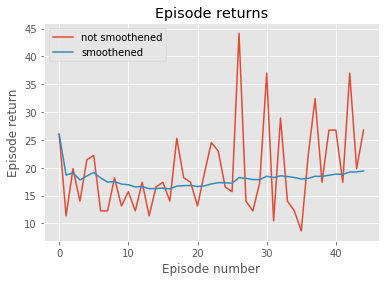

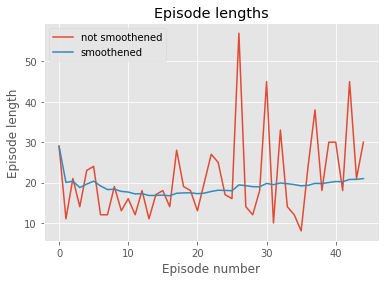

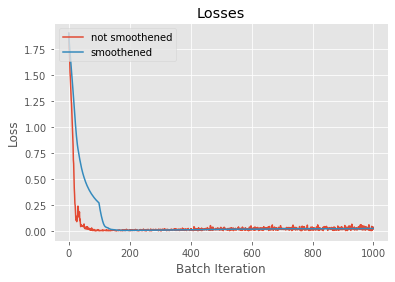

In [11]:
plot_all(returns, lengths, q1_losses)

In [12]:
save_results(returns, lengths, policy_losses)

In [14]:
print(len(lengths))
print(len(returns))

45
45
